In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
jam = pd.read_csv("./jam3.csv")

X = jam["text"]
y = jam["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify = y)

pipe_tv_sv = Pipeline([
    ("tvec", TfidfVectorizer()),
    ("svc", svm.SVC())
])

pipe_params = {
    "tvec__max_features"    : [5_000],
    "tvec__ngram_range"     : [(1,1)],
    "tvec__stop_words"      : ["english"],
    "svc__C"                : [10],
    "svc__kernel"           : ["rbf"],
    "svc__gamma"            : ["scale"]
}

gs_tv_sv = GridSearchCV(pipe_tv_sv, param_grid=pipe_params, cv=5)
gs_tv_sv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': [5000], 'tvec__ngram_range': [(1, 1)], 'tvec__stop_words': ['english'], 'svc__C': [10], 'svc__kernel': ['rbf'], 'svc__gamma': ['scale']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

I am interested in exploring the model's misclassifications. I want to know which key words occur the most frequently in misclassifications. Also, I want to know if misclassifications are imbalanced at all towards one class.

In [3]:
# Generating predictions on testing data
y_test_hat = gs_tv_sv.predict(X_test)

In [4]:
# Generating predictions on training data
y_train_hat = gs_tv_sv.predict(X_train)

In [5]:
# Building a dataframe of misclassifications with the post,
# the predicted class, and the actual class

train_eval = pd.DataFrame({"text" : X_train,
                           "pred" : y_train_hat,
                           "true" : y_train})

train_eval["pred"] = train_eval["pred"].map({0: "Dead",
                                             1: "Phish"})

train_eval["true"] = train_eval["true"].map({0: "Dead",
                                             1: "Phish"})

test_eval = pd.DataFrame({"text" : X_test,
                          "pred" : y_test_hat,
                          "true" : y_test})

test_eval["pred"] = test_eval["pred"].map({0: "Dead",
                                           1: "Phish"})

test_eval["true"] = test_eval["true"].map({0: "Dead",
                                           1: "Phish"})

train_misclass = train_eval[train_eval["pred"] != train_eval["true"]]
test_misclass = test_eval[test_eval["pred"] != test_eval["true"]]

train_misclass.reset_index(inplace=True, drop=True)
test_misclass.reset_index(inplace=True, drop=True)

In [6]:
train_misclass.head()

,text,pred,true
0,any spare pre sale code out there don t have a...,Phish,Dead
1,orlando 2 27 xpost from r deadandcompany looki...,Phish,Dead
2,billy string i’m sure others have posted this ...,Phish,Dead
3,jrad presale password for redrocks they said t...,Dead,Phish
4,man the band get out of there fast i left the ...,Dead,Phish


In [7]:
test_misclass.head()

,text,pred,true
0,anyone heard any rumor about a summer tour fuc...,Phish,Dead
1,mr and mr wallob were jerk to name their kid c...,Dead,Phish
2,since we were just celebrating fall 1997 how a...,Dead,Phish
3,want to meet johnny checker some dude over in ...,Phish,Dead
4,sweet jane they should play this song more jus...,Dead,Phish


In [8]:
train_misclass["true"].value_counts()

Dead     260
Phish    227
Name: true, dtype: int64

In [9]:
test_misclass["true"].value_counts()

Dead     161
Phish    142
Name: true, dtype: int64

The misclassification classes are fairly balanced, but the model is substantially more likely to incorrectly classify a post from the Dead subreddit vs the Phish subreddit.

Now, I'll scan through the posts. I'll print a few of them below, but I found that there were some common types of misclassifications:
- General music/concert discussion that does not include any band-specific terminology. These are posts that I would not have been able to reliably classify, because they were too vague.
- Crossover discussion of one band in the other band's subreddit. These are posts that I probably could classify, but not necessarily.
- Posts that had some band-specific language that was not clear enough for the model to correctly predict. These are posts that I would be able to easily classify as someone with subject matter knowledge.

In [10]:
for i in range(5):
    print(f"class: {test_misclass['true'][i]}_________{test_misclass['text'][i]}")

class: Dead_________anyone heard any rumor about a summer tour fuck em if they can t take a joke j garcia
class: Phish_________mr and mr wallob were jerk to name their kid clueless way to set clueless up for failure out the gate
class: Phish_________since we were just celebrating fall 1997 how about some love for bittersweet motel while not exclusively about fall winter 1997 there were some great moment in the film i’d love a where are they now special for some of my favorite character in the movie rochester fairy miracle girl europe no drug that place guy campground pot frat bros morning dancing balloon girl head cut off in picture with the band feel free to add your favorite
class: Dead_________want to meet johnny checker some dude over in r johnmayer ha an extra syracuse meet n greet ticket
class: Phish_________sweet jane they should play this song more just played the halloween version on sirius and looked it up to see they ve only played it 4 time great song and they shred it


In [11]:
for i in range(5):
    print(f"class: {train_misclass['true'][i]}_________{train_misclass['text'][i]}")

class: Dead_________any spare pre sale code out there don t have a pre sale code and so badly would like to get 2 lawn ticket to the saratoga spring show for my girlfriend and i hate to ask thanks
class: Dead_________orlando 2 27 xpost from r deadandcompany lookin to trade my 2ga ticket with some cash for 3 ga ticket friend got off work and we all want to sit together mine are bleeder i can throw in extra money if you have more expensive seat
class: Dead_________billy string i’m sure others have posted this listen to go see billy string
class: Phish_________jrad presale password for redrocks they said they would email anyone willing to share w me thanks all
class: Phish_________man the band get out of there fast i left the show last night towards the end of show of life i had a bus to catch and didn t want to risk being late during the last few note of show of life i bolted out the door next to me and fast walked jogged to the exit i had planned for being the best way out shortly after

Now, I'll count the words that appear in misclassified posts to identify some key words that frequently appear in misclassified posts. 

In [12]:
misclass_all = train_misclass.merge(test_misclass, how="outer")

In [13]:
cv = CountVectorizer()
misclass_cv = cv.fit_transform(misclass_all["text"])

In [14]:
misclass_word_counts = pd.DataFrame(misclass_cv.toarray(),
                                    columns=cv.get_feature_names())

In [15]:
misclass_wc_list = [(col, misclass_word_counts[col].sum()) 
 for col in misclass_word_counts.columns]

In [16]:
mc_word_counts = pd.DataFrame(misclass_wc_list, 
                              columns = ["word", "count"])

In [17]:
mc_word_counts.sort_values("count", ascending=False).head(10)

,word,count
3580,the,1416
3650,to,1017
294,and,788
1444,for,578
2474,of,526
1832,in,470
1909,it,461
1899,is,365
3218,show,353
2493,on,344


In [18]:
# Scanning through the above dataframe, the following words were the
# "buzzwords" (music-related or band-related language) that occured
# most frequently in misclassified posts.


bwords = ["show", "ticket", "show", "tour", "band", "dead", "phish", 
          "seat", "summer", "face", "music", "extra", "jam", "song", 
          "set", "msg", "lawn", "camping"]

In [19]:
misclass_buzz = mc_word_counts[mc_word_counts["word"].isin(bwords)].\
sort_values("count", ascending=False)

misclass_buzz["rate"] = misclass_buzz["count"] / len(misclass_buzz)

In [20]:
plt.style.use("seaborn-poster")
plt.style.use("ggplot")

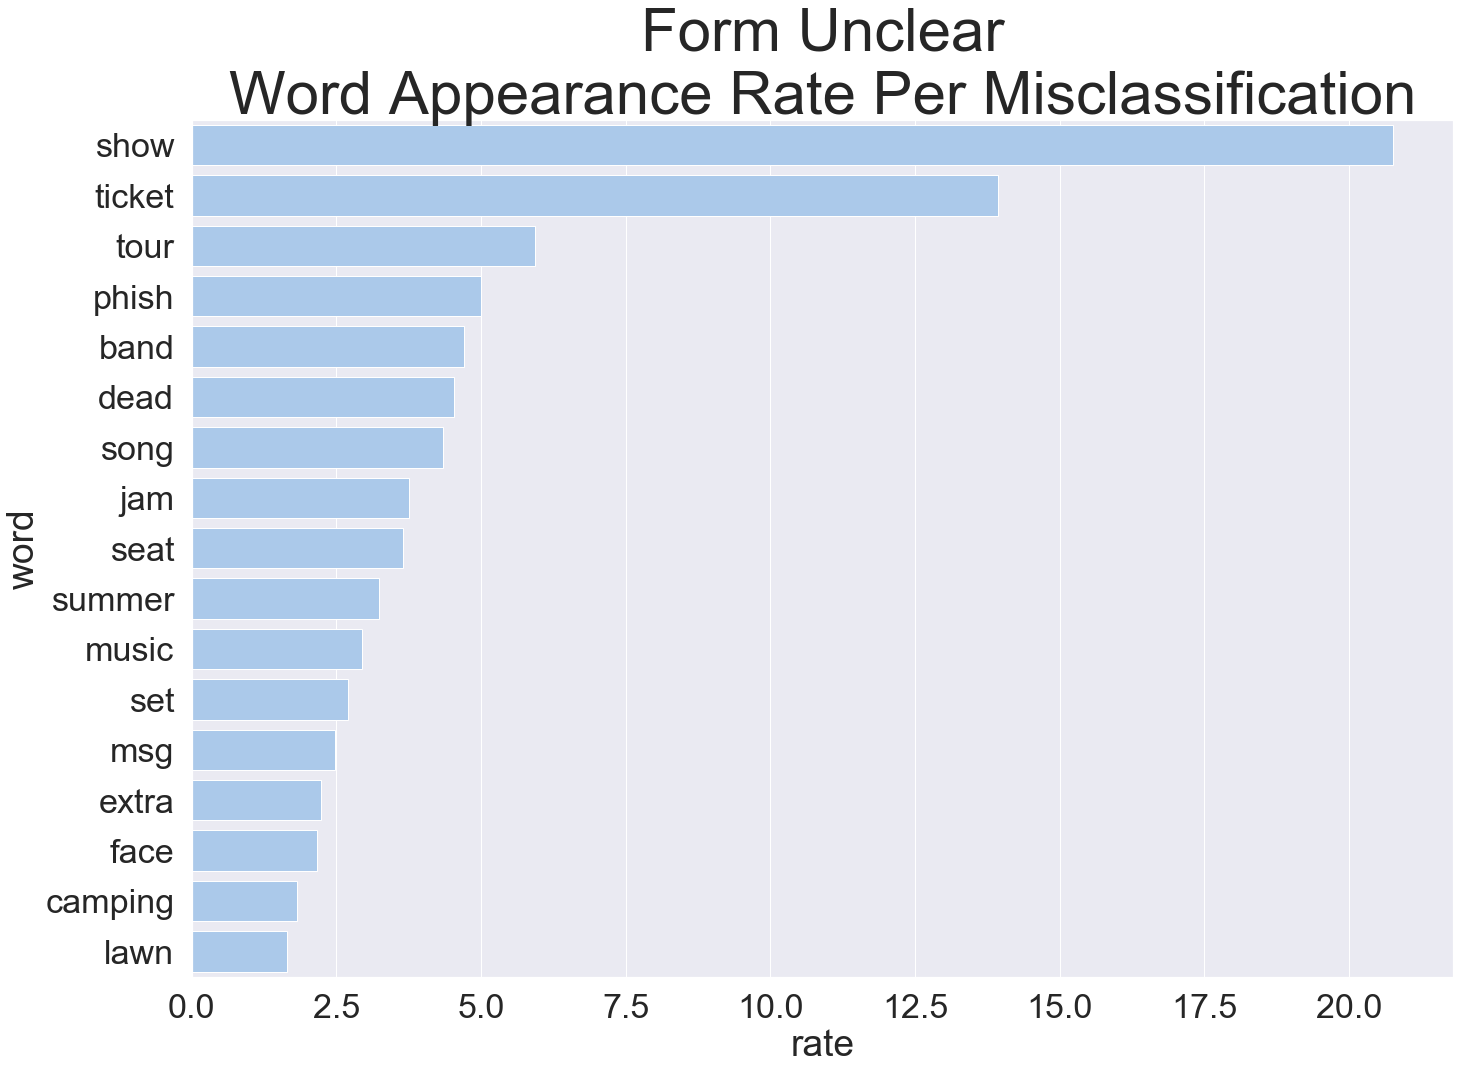

In [33]:
# Plotting the most frequent key words with the rate at which they
# appear in misclassified posts

plt.figure(figsize=(21.5, 16))
plt.title("Form Unclear\nWord Appearance Rate Per Misclassification", fontsize=60)
sns.set(font_scale=3.7)
sns.set_color_codes("pastel")
sns.barplot(x="rate", y="word", data=misclass_buzz, color="b");
plt.tight_layout()

plt.savefig("./form-unclear.png")

Now, I'll investigate which key words show up most frequently in Dead posts and in Phish posts.

In [22]:
dead = pd.read_csv("./dead.csv")
phish = pd.read_csv("./phish.csv")

dead.fillna("", inplace=True);
phish.fillna("", inplace=True);

dead["text"] = dead["title"] + " " + dead["selftext"]
phish["text"] = phish["title"] + " " + phish["selftext"]

dead.drop(columns = [col for col in dead.columns if col not in ["text", "subreddit"]],
          inplace=True)

phish.drop(columns = [col for col in phish.columns if col not in ["text", "subreddit"]],
          inplace=True)

dead.reset_index(inplace=True, drop=True)
phish.reset_index(inplace=True, drop=True)

dead["text"] = dead["text"].map(lambda x: x.replace("\n", " "))
phish["text"] = phish["text"].map(lambda x: x.replace("\n", " "))

dead["text"] = dead["text"].map(lambda x: re.sub("\[deleted\]", " ", x))
phish["text"] = phish["text"].map(lambda x: re.sub("\[deleted\]", " ", x))

dead["text"] = dead["text"].map(lambda x: re.sub("\[removed\]", " ", x))
phish["text"] = phish["text"].map(lambda x: re.sub("\[removed\]", " ", x))

# I referred to this stackoverflow page for help on this:
# https://stackoverflow.com/questions/8122079/
# python-how-to-check-a-string-for-substrings-from-a-list

def drop_url(text):
    text_list = text.split()
    url_tags = ["http", ".com", "www.", ".org", ".net", "&amp", "width=", "size=", "width=",
                "height=", "style=", "scrolling=", "allowFullScreen=", "frameborder=", 
                "allowTransparency=", "iframe", "&gt", "&lt"]
    
    filtered_list = [word for word in text_list if any(tag in word for tag in url_tags) == False]
    
    return " ".join(filtered_list)

dead["text"] = dead["text"].map(lambda x: drop_url(x))
phish["text"] = phish["text"].map(lambda x: drop_url(x))

dead = dead.drop(dead[dead["text"] == ""].index)
dead.reset_index(inplace=True, drop=True)

phish = phish.drop(phish[phish["text"] == ""].index)
phish.reset_index(inplace=True, drop=True)

In [23]:
cv = CountVectorizer()
dead_cv = cv.fit_transform(dead["text"])

dead_word_counts = pd.DataFrame(dead_cv.toarray(),
                                    columns=cv.get_feature_names())

dead_cv_list = [(col, dead_word_counts[col].sum()) for col in dead_word_counts.columns]

dead_wc = pd.DataFrame(dead_cv_list, columns = ["word", "count"])

In [24]:
cv = CountVectorizer()
phish_cv = cv.fit_transform(phish["text"])

phish_word_counts = pd.DataFrame(phish_cv.toarray(),
                                    columns=cv.get_feature_names())

phish_cv_list = [(col, phish_word_counts[col].sum()) for col in phish_word_counts.columns]

phish_wc = pd.DataFrame(phish_cv_list, columns = ["word", "count"])

In [25]:
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

The following words are the buzzwords that showed up most frequently in the Dead posts and the Phish posts.

In [26]:
deadwords = [lem.lemmatize(i) for i in 
            ["dead", "grateful", "jerry", "dark", "phil", "bobby", "star", 
             "john", "company", "bob", "72", "drums",
             "picks", "shakedown", "gd", "china", "space", "77", "garcia", 
             "morning", "eyes", "terrapin", "uncle", 
             "rider"]]

In [27]:
phishwords = [lem.lemmatize(i) for i in ["phish", "trey", "mike", "curveball", "dozen", "page", "dicks", "livephish", "ptbm", "phans", "code", 
              "tweezer", "bd", "bakers", "baker", "ghost", "groove", "hood", "gin", "phan", "fish", "yem", "tube", 
              "fishman"]]

In [28]:
dead_wc = dead_wc[dead_wc["word"].isin(deadwords)].\
sort_values("count", ascending=False)

In [29]:
phish_wc = phish_wc[phish_wc["word"].isin(phishwords)].\
sort_values("count", ascending=False)

In [30]:
dead_wc["rate"] = dead_wc["count"] / len(dead) * 100
phish_wc["rate"] = phish_wc["count"] / len(phish) * 100

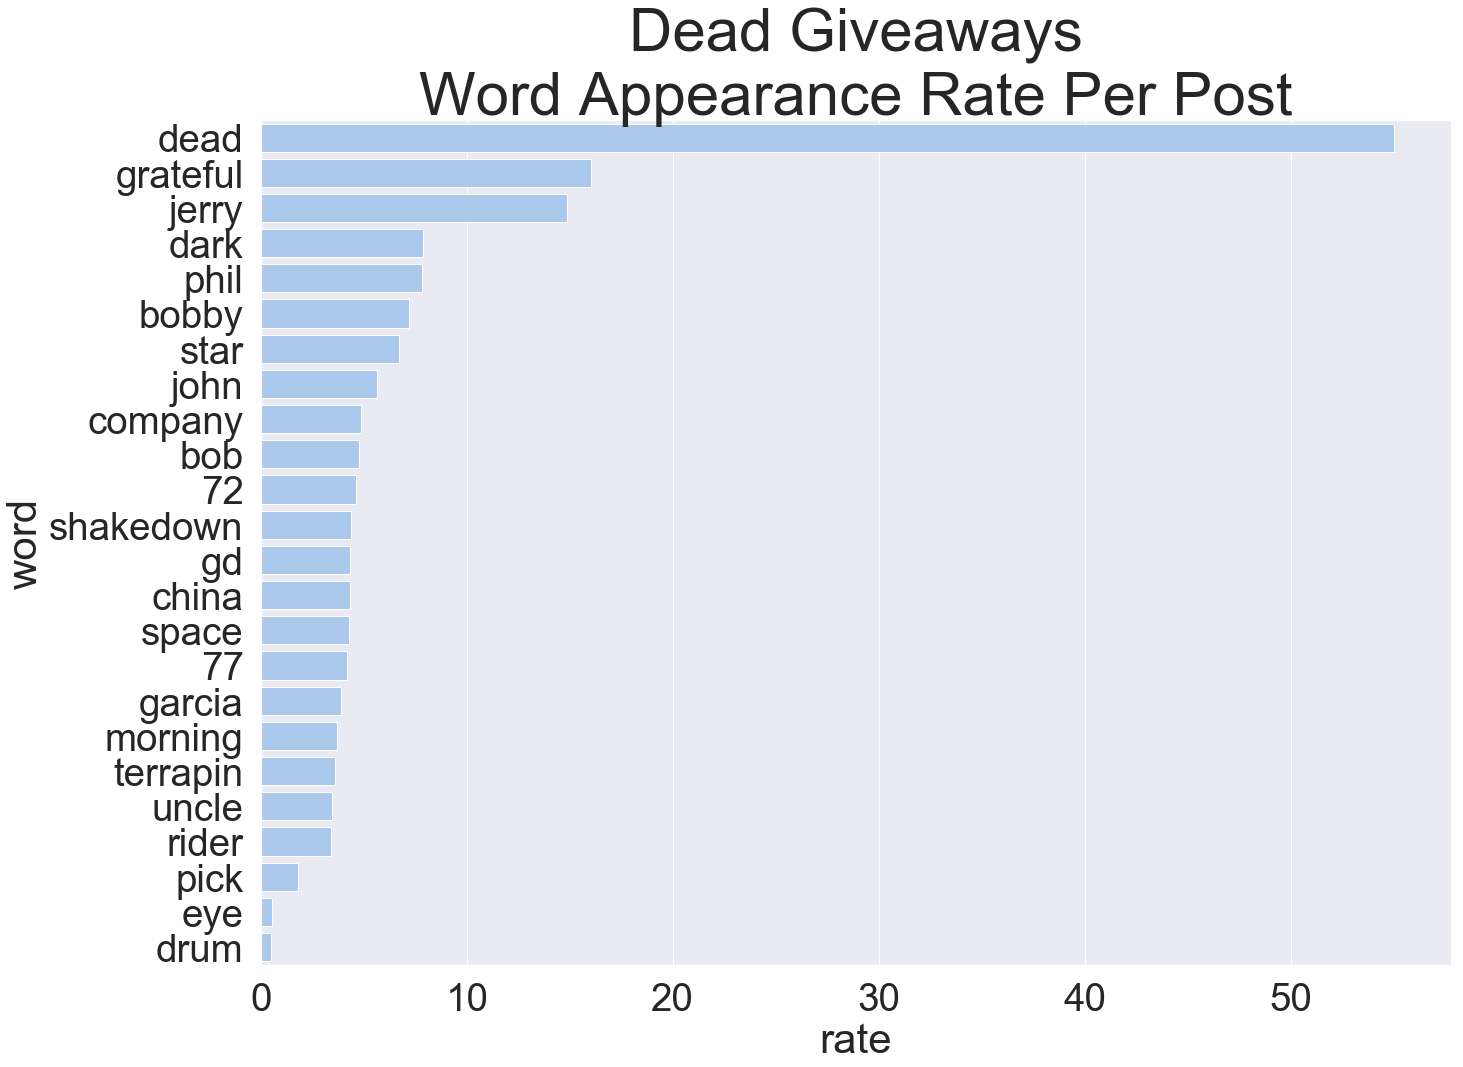

In [31]:
plt.figure(figsize=(21.5, 16))
plt.title("Dead Giveaways\nWord Appearance Rate Per Post", fontsize=60)
sns.set(font_scale=3.8)
sns.set_color_codes("pastel")
sns.barplot(x="rate", y="word", data=dead_wc, color="b");
plt.tight_layout()
plt.savefig("./dead-giveaway.png")

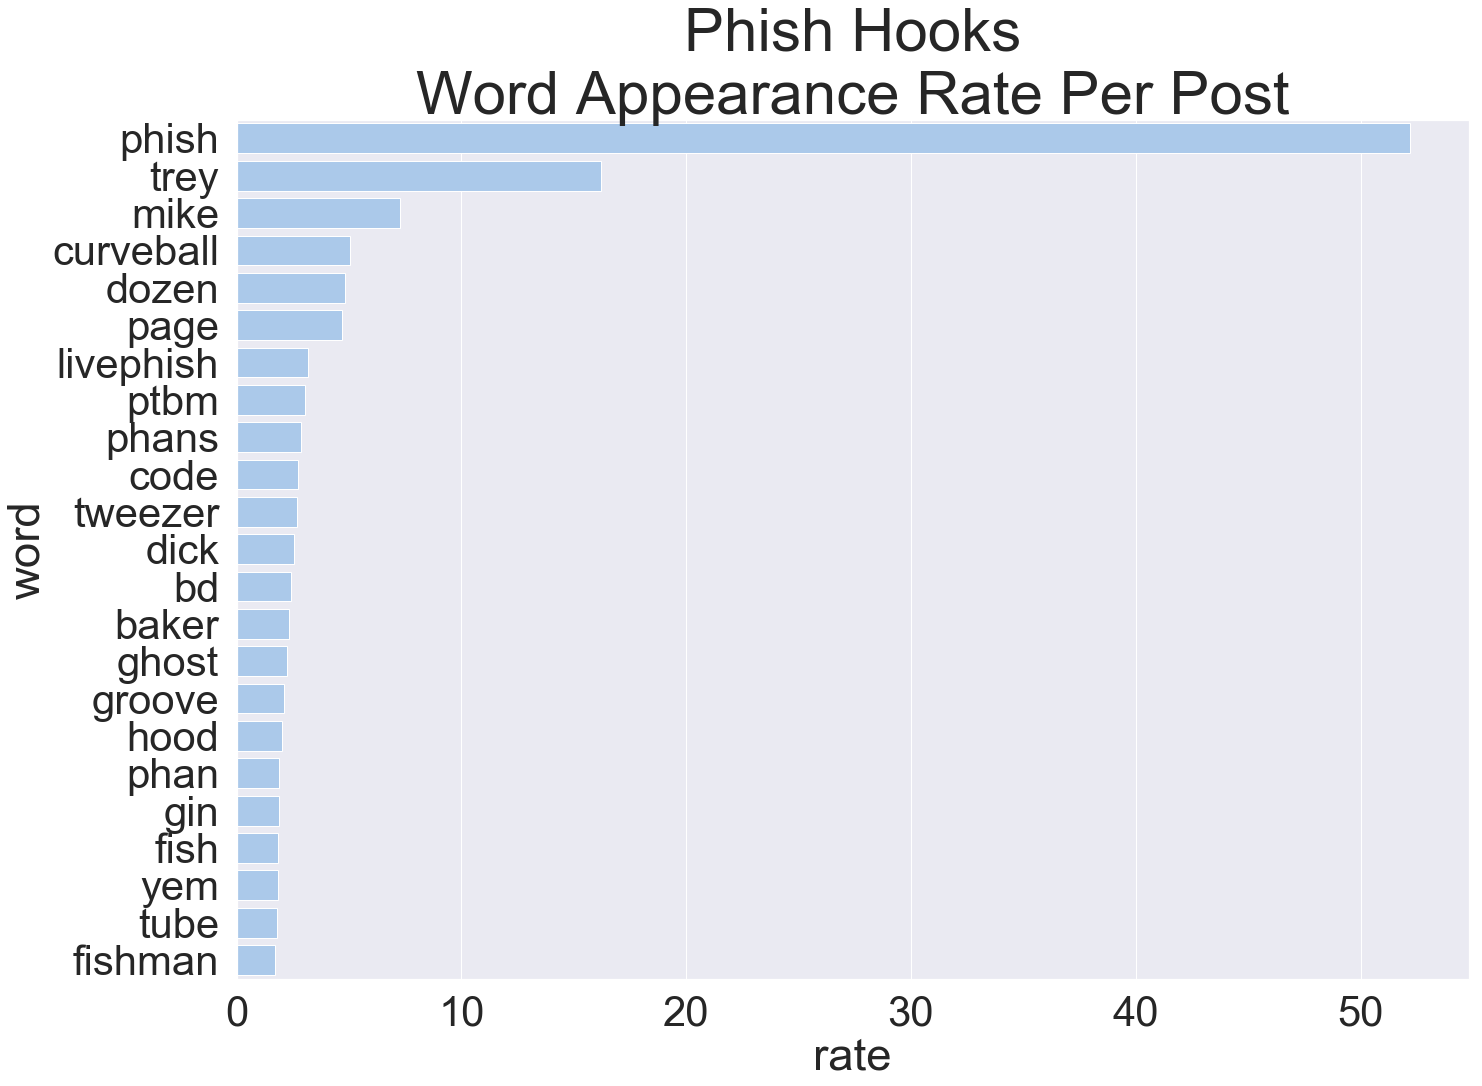

In [32]:
plt.figure(figsize=(21.5, 16))
plt.title("Phish Hooks\nWord Appearance Rate Per Post", fontsize=60)
sns.set(font_scale=3.1)
sns.set_color_codes("pastel")
sns.barplot(x="rate", y="word", data=phish_wc, color="b");
plt.tight_layout()
plt.savefig("./phish-hooks.png")

## Conclusions

This was an interesting exercise in testing out a variety of different NLP models. I think the performance of my models was generally quite good, but I'm sure it could be better. My first idea to improve the model from here in the future would be to acquire more data. I would either do this by getting more posts, or by including the comment text for each of the posts that I analyzed for this modeling process.

To some extent, I think it is reasonable that there would be some amount of bias in any model classifying posts between these subreddits. Both subreddits contain a fair amount of similar conversation about music and concerts in general that don't necessarily specifically pertain to either band. Also, both message boards contain a lot of conversation pertaining to the other band. Phish and the Grateful Dead share a lot of fans, and there is a lot of discussion about both bands in both subreddits. At the same time, getting more data would allow the model to have a better sense of all of the band-specific language like band member names, song/album titles, etc.

Interestingly, some of the top buzzwords for each band were common words in both subreddits. Since there is a lot of crossover discussion between the forums, "Phish" and "Dead" are words that, while especially likely to occur in their respective subreddits, are also fairly likely to appear in the other subreddit. This means that simply having a "buzzword" is not enough to correctly classify each post. This would likely be a factor in many of the misclassifications.

It would be interesting to repeat this exercise with two other subreddits of bands that were not as closely linked in terms of their fanbases. It would also be interesting to repeat the exercise on two non-music subreddits. I wonder how the accuracy would compare and if the same kind of model would emerge as the best one.

Another idea that I have is that it might be possible to build a buzzword library that includes any band member names, song titles, and album titles. This might be basically accomplished simply by using larger datasets, but it also wouldn't be that hard to generate such a list manually. In any case, I wonder how a model like that would perform that only considered band-specific language. Of course, it would be basically guessing on posts that were vague, and it would still be susceptible to incorrectly classifying crossover posts, but maybe it would perform well overall. When I was scanning through the lists of wordcounts for each subreddit, I was noticing that most of the top words were all general language and not key terminology or buzzwords. I was expecting there to be more of a concentration of band-specific buzzwords at the top of the list, but that wasn't exactly the case.

Anyway, this project was a good introduction to NLP and some of the various models that can be used for NLP analysis.